[PATH] FE     : C:\Users\seo58\OneDrive\바탕 화면\capstone02_project_final\capstone02_project\results\stageG\stageG_FE_v1.parquet
[PATH] MODEL  : C:\Users\seo58\OneDrive\바탕 화면\capstone02_project_final\capstone02_project\results\stageI\stageI_final_lgbm_model.pkl
[PATH] SCALER : C:\Users\seo58\OneDrive\바탕 화면\capstone02_project_final\capstone02_project\results\stageI\stageI_final_scaler.pkl
[PATH] SAVE   : C:\Users\seo58\OneDrive\바탕 화면\capstone02_project_final\capstone02_project\results\stageH
FE shape: (1567, 330)
Train: (1253, 329)  Test: (314, 329)
[OK] 모델 & 스케일러 로드 완료
[OK] y_test_prob / y_test_pred 계산 완료


c:\Users\seo58\OneDrive\바탕 화면\capstone02_project_final\capstone02\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Metric,Value
0,Accuracy,0.910828
1,Precision,0.333333
2,Recall,0.333333
3,Specificity,0.952218
4,F1 Score,0.333333
5,Balanced Accuracy,0.642776
6,ROC-AUC,0.810011
7,PR-AUC,0.226450
8,TN,279.000000
9,FP,14.000000



[Confusion Matrix] TN=279.0, FP=14.0, FN=14.0, TP=7.0

[PR-AUC]  0.226450
[ROC-AUC] 0.810011


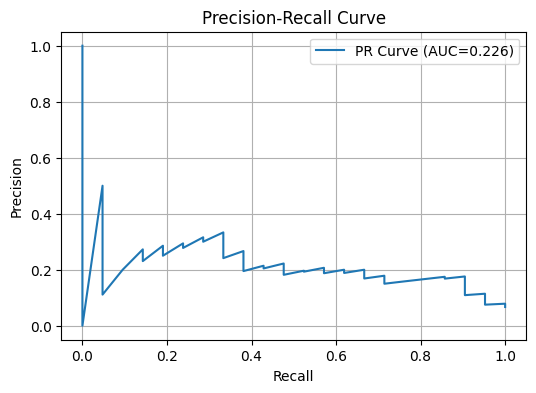

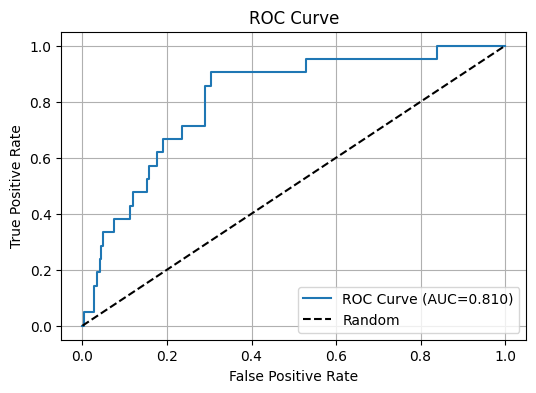


[✅ DONE] PR / ROC curve 데이터 저장 완료
 - PR  : C:\Users\seo58\OneDrive\바탕 화면\capstone02_project_final\capstone02_project\results\stageH\pr_curve_stageH.csv
 - ROC : C:\Users\seo58\OneDrive\바탕 화면\capstone02_project_final\capstone02_project\results\stageH\roc_curve_stageH.csv


In [2]:
# ============================================
# ✅ Stage H — 최종 모델 다시 불러와서
#    - y_test, y_test_prob 재계산
#    - metric_table / Confusion Matrix / PR/ROC 곡선 만들기
#    - (원하면 CSV로 저장해서 대시보드에서 사용)
# ============================================

from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, average_precision_score,
    balanced_accuracy_score, precision_recall_curve, roc_curve
)

import joblib
import matplotlib.pyplot as plt

# ------------------------------------
# 1) 경로 설정 (네 프로젝트 기준)
#    👉 필요하면 여기 ROOT만 네 폴더에 맞게 수정해도 돼
# ------------------------------------
ROOT = Path(r"C:\Users\seo58\OneDrive\바탕 화면\capstone02_project_final\capstone02_project")

FE_PATH     = ROOT / "results" / "stageG" / "stageG_FE_v1.parquet"
MODEL_PATH  = ROOT / "results" / "stageI" / "stageI_final_lgbm_model.pkl"
SCALER_PATH = ROOT / "results" / "stageI" / "stageI_final_scaler.pkl"
SAVE_DIR    = ROOT / "results" / "stageH"
SAVE_DIR.mkdir(parents=True, exist_ok=True)

print("[PATH] FE     :", FE_PATH)
print("[PATH] MODEL  :", MODEL_PATH)
print("[PATH] SCALER :", SCALER_PATH)
print("[PATH] SAVE   :", SAVE_DIR)

# ------------------------------------
# 2) 데이터 로드 + Train/Test Split (8:2, Stage H와 동일)
# ------------------------------------
df_fe = pd.read_parquet(FE_PATH)
print("FE shape:", df_fe.shape)

target_col = "label"
X = df_fe.drop(columns=[target_col])
y = df_fe[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42,   # 🔥 Stage H랑 똑같이!
)
print("Train:", X_train.shape, " Test:", X_test.shape)

# ------------------------------------
# 3) 스케일러 & 최종 모델 로드
# ------------------------------------
scaler = joblib.load(SCALER_PATH)
model  = joblib.load(MODEL_PATH)
print("[OK] 모델 & 스케일러 로드 완료")

X_test_scaled = scaler.transform(X_test)
y_test_prob = model.predict_proba(X_test_scaled)[:, 1]
y_test_pred = (y_test_prob >= 0.6429997389333499).astype(int)  # 🔥 Stage I Best F1 Threshold

print("[OK] y_test_prob / y_test_pred 계산 완료")

# ------------------------------------
# 4) 수치 성능표(metric_table) 계산
# ------------------------------------
def eval_numeric_metrics(y_true, y_pred, y_prob):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)

    return pd.DataFrame({
        "Metric": [
            "Accuracy", "Precision", "Recall", "Specificity",
            "F1 Score", "Balanced Accuracy", "ROC-AUC", "PR-AUC",
            "TN", "FP", "FN", "TP"
        ],
        "Value": [
            acc, precision, recall, specificity,
            f1, bal_acc, roc, pr_auc,
            tn, fp, fn, tp
        ]
    })

metric_table = eval_numeric_metrics(y_test, y_test_pred, y_test_prob)
display(metric_table)

# ------------------------------------
# 5) Confusion Matrix 값 찍어보기 (체크용)
# ------------------------------------
tn, fp, fn, tp = metric_table.set_index("Metric").loc[["TN","FP","FN","TP"], "Value"]
print(f"\n[Confusion Matrix] TN={tn}, FP={fp}, FN={fn}, TP={tp}")

# ------------------------------------
# 6) PR / ROC 곡선 계산 (진짜 데이터 기반)
# ------------------------------------
precisions, recalls, _ = precision_recall_curve(y_test, y_test_prob)
fpr, tpr, _ = roc_curve(y_test, y_test_prob)

pr_auc  = average_precision_score(y_test, y_test_prob)
roc_auc = roc_auc_score(y_test, y_test_prob)

print(f"\n[PR-AUC]  {pr_auc:.6f}")
print(f"[ROC-AUC] {roc_auc:.6f}")

# ------------------------------------
# 7) 곡선 시각화 (노트북에서 확인용)
# ------------------------------------
plt.figure(figsize=(6,4))
plt.plot(recalls, precisions, label=f"PR Curve (AUC={pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid(True)
plt.legend()
plt.show()

# ------------------------------------
# 8) 대시보드에서 쓰려면 PR/ROC 점들을 CSV로 저장
# ------------------------------------
pr_df = pd.DataFrame({"recall": recalls, "precision": precisions})
roc_df = pd.DataFrame({"fpr": fpr, "tpr": tpr})

pr_path  = SAVE_DIR / "pr_curve_stageH.csv"
roc_path = SAVE_DIR / "roc_curve_stageH.csv"

pr_df.to_csv(pr_path, index=False)
roc_df.to_csv(roc_path, index=False)

print("\n[✅ DONE] PR / ROC curve 데이터 저장 완료")
print(" - PR  :", pr_path)
print(" - ROC :", roc_path)
